<a href="https://colab.research.google.com/github/yasararafath-s/Sentiment_analysis_imdb_lstm/blob/main/Sentiment_Analysis_of_IMDB_Movie_Reviews_Using_LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of IMDB Movie Reviews Using LSTM_pytorch

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load and preprocess data
max_features = 10000  # Vocabulary size
max_len = 500         # Max length of sequences

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

def pad_sequences(data, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen] for seq in data]

x_train = pad_sequences(x_train, max_len)
x_test = pad_sequences(x_test, max_len)

# Data Preview
print("Data Sample (as integers):", x_train[0])
print("Label Sample:", y_train[0])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data Sample (as integers): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5

In [ ]:
# PyTorch Dataset and DataLoader
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Define the PyTorch Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden[-1])
        return self.sigmoid(x)

model = LSTMModel(max_features, 128, 64)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the Model
train_loss_values = []
val_loss_values = []

def train_and_validate_model():
    model.train()
    for epoch in range(5):
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_values.append(train_loss)

        # Validation Loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        val_loss_values.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

In [ ]:
# Evaluation and Metrics
all_predictions = []
all_labels = []

def evaluate_model():
    model.eval()
    global all_predictions, all_labels
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predictions = (outputs.squeeze() > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix - PyTorch')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix_pytorch.png')
    plt.show()

Epoch 1, Train Loss: 0.6933, Validation Loss: 0.6941
Epoch 2, Train Loss: 0.6910, Validation Loss: 0.6939
Epoch 3, Train Loss: 0.6838, Validation Loss: 0.6960
Epoch 4, Train Loss: 0.6657, Validation Loss: 0.7067
Epoch 5, Train Loss: 0.6488, Validation Loss: 0.7196
Accuracy: 0.5084, Precision: 0.5934, Recall: 0.0534, F1 Score: 0.0979


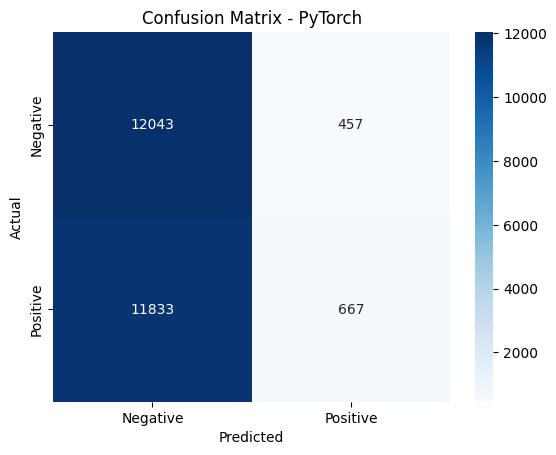

In [ ]:
# Training and Evaluation
train_and_validate_model()
evaluate_model()

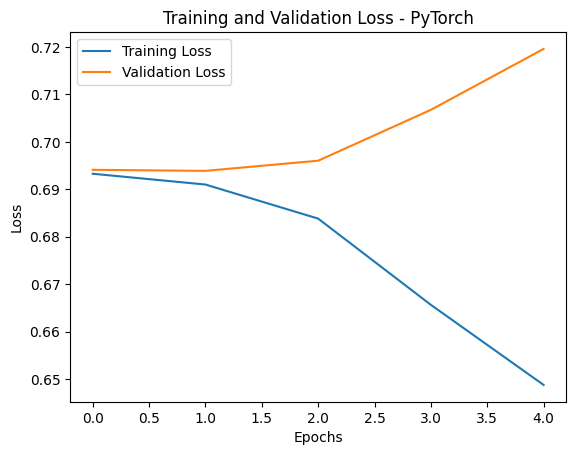

In [ ]:
# Plot Loss Curves
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss - PyTorch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot_pytorch.png')
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), 'lstm_SA_imdb_model.pth')
print("Model saved successfully!")

Model saved successfully!
